In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=100000) # just read first 100000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        data.append(jet)

In [7]:
data = np.array(data)
data.shape

(1477373, 4)

In [8]:
# log transform pT
#data[:,3] = np.ma.log(data[:,3]).filled()

In [9]:
data

array([[-1.17658220e+03, -7.79040316e+02,  3.40962660e+02,
         1.45491963e+03],
       [ 6.11088616e+02,  7.16513394e+02,  1.55833044e+03,
         1.87194199e+03],
       [ 4.96094722e+02, -1.87111748e+01,  1.78940558e+03,
         1.85808569e+03],
       ...,
       [ 4.42306312e-01,  9.70780337e-02,  2.58945478e+01,
         2.58985070e+01],
       [-2.68772115e-01, -3.44070287e-01, -3.01572220e+01,
         3.01603823e+01],
       [-2.82745626e-01, -7.48815701e-02, -9.38791569e+00,
         9.39247109e+00]])

In [10]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [11]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# VAE Model

In [12]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [13]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
inter_dim_1 = 16
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [15]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim)(h3)

In [16]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [17]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [18]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = mse(x, y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [19]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144     

# Train

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
batch_size = 1000
epochs = 100

In [22]:
x_train.shape

(1181898, 4)

In [23]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [24]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 1181898 samples, validate on 147737 samples
Epoch 1/100
1181898/1181898 [==============================] - 11s 10us/step - loss: 0.2972 - val_loss: 0.1748
Epoch 2/100
1181898/1181898 [==============================] - 10s 9us/step - loss: 0.1399 - val_loss: 0.1033
Epoch 3/100
1181898/1181898 [==============================] - 10s 9us/step - loss: 0.0906 - val_loss: 0.0801
Epoch 4/100
1181898/1181898 [==============================] - 8s 7us/step - loss: 0.0733 - val_loss: 0.0670
Epoch 5/100
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0649 - val_loss: 0.0625
Epoch 6/100
1181898/1181898 [==============================] - 9s 8us/step - loss: 0.0604 - val_loss: 0.0582
Epoch 7/100
1181898/1181898 [==============================] - 9s 8us/step - loss: 0.0579 - val_loss: 0.0571
Epoch 8/100
1181898/1181898 [==============================] - 9s 8us/step - loss: 0.0544 - val_loss: 0.0517
Epoch 9/100
1181898/1181898 [==============================] - 9s 8us/s

# Visualization

In [25]:
import matplotlib.pyplot as plt

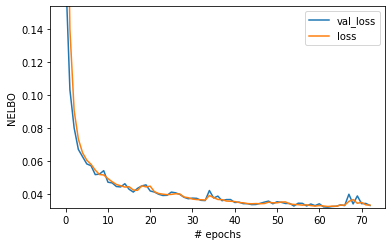

In [26]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [27]:
predictions = vae.predict(x_test)

In [28]:
predictions

array([[-9.5884502e-04,  5.6366026e-03, -3.3641636e-02, -4.7911471e-01],
       [-7.5654685e-04,  2.6030213e-02, -2.0530540e-01, -4.0508780e-01],
       [-3.1583011e-04,  7.6567233e-03,  7.8493953e-03, -4.9372774e-01],
       ...,
       [ 2.4306327e-03,  9.9267066e-03,  5.0237834e-02, -4.6117729e-01],
       [ 5.1481277e-03, -2.6258826e-04, -6.5738976e-02, -4.6009445e-01],
       [ 1.8546134e-03,  4.4232905e-03, -2.1239102e-02, -4.8402095e-01]],
      dtype=float32)

In [29]:
distr = (x_test - predictions) / x_test

In [30]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [31]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

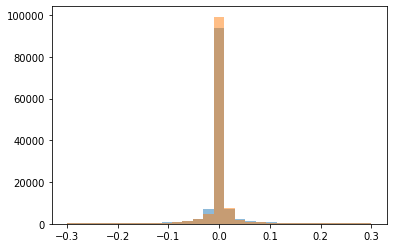

In [32]:
bins = np.linspace(-0.3, 0.3, 30)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)
bins = np.linspace(-0.45, -0.2, 40)

(array([   91.,   124.,   123.,   137.,   137.,   140.,   160.,   241.,
          316.,   333.,   325.,   364.,   511.,  1357., 84188., 23983.,
         6783.,  2802.,  1012.,   684.,   471.,   365.,   274.,   222.,
          185.,   166.,   149.,   104.,   103.]),
 array([-0.3       , -0.27931034, -0.25862069, -0.23793103, -0.21724138,
        -0.19655172, -0.17586207, -0.15517241, -0.13448276, -0.1137931 ,
        -0.09310345, -0.07241379, -0.05172414, -0.03103448, -0.01034483,
         0.01034483,  0.03103448,  0.05172414,  0.07241379,  0.09310345,
         0.1137931 ,  0.13448276,  0.15517241,  0.17586207,  0.19655172,
         0.21724138,  0.23793103,  0.25862069,  0.27931034,  0.3       ]),
 <a list of 29 Patch objects>)

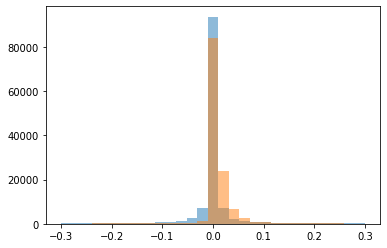

In [33]:
bins = np.linspace(-0.3, 0.3, 30)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

(array([  247.,   673.,  1291.,   993.,  1167.,  1433.,  1541.,  1431.,
         1688.,  2099.,  3197.,  4672.,  7344., 13920., 37062., 11843.,
         6441.,  4117.,  2968.,  2196.,  1683.,  1385.,  1105.,   968.,
          821.,   741.,   614.,   531.,   547.]),
 array([-0.3       , -0.27931034, -0.25862069, -0.23793103, -0.21724138,
        -0.19655172, -0.17586207, -0.15517241, -0.13448276, -0.1137931 ,
        -0.09310345, -0.07241379, -0.05172414, -0.03103448, -0.01034483,
         0.01034483,  0.03103448,  0.05172414,  0.07241379,  0.09310345,
         0.1137931 ,  0.13448276,  0.15517241,  0.17586207,  0.19655172,
         0.21724138,  0.23793103,  0.25862069,  0.27931034,  0.3       ]),
 <a list of 29 Patch objects>)

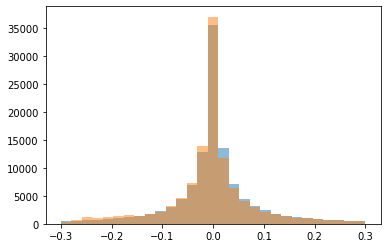

In [34]:
bins = np.linspace(-0.3, 0.3, 30)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 85186., 20459.,  4411.,  2715.,  2905.,  1771.,
         1310.,  1259.,  1007.,   774.,   706.,   661.,   599.,   557.,
          485.,   368.,   328.,   252.,   241.,   231.,   219.,   321.,
          440.,   615.,   727.,  1060.,  1133.,  2762.,  1377.,  1175.,
         1107.]),
 array([-2.        , -1.91836735, -1.83673469, -1.75510204, -1.67346939,
        -1.59183673, -1.51020408, -1.42857143, -1.34693878, -1.26530612,
        -1.18367347, -1.10204082, -1.02040816, -0.93877551, -0.85714286,
        -0.7755102 , -0.69387755, -0.6122449 , -0.53061224, -0.44897959,
        -0.36734694, -0.28571429, -0.20408163, -0.12244898, -0.04081633,
         0.04081633,  0.12244898,  0.20408163,  0.28571429,  0.36734694,
         0.44897959,  0.53061224,  0.6122449 ,  0.69387755,  0.7755102 ,
         0.85714286,  0.93877551,  1.02

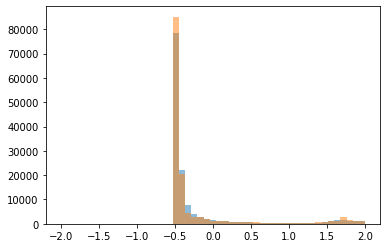

In [35]:
bins = np.linspace(-2,2, 50)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [36]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [37]:
bins = np.linspace(-2, 2, 30)

(array([  699.,   744.,   853.,   826.,   933.,  1096.,  1247.,  1366.,
         1607.,  1834.,  2152.,  2807.,  4038.,  7588., 12944.,  9643.,
         7995.,  7801.,  8134.,  9744.,  9019.,  5461.,  3860.,  3018.,
         2348.,  1992.,  1790.,  1541.,  1374.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

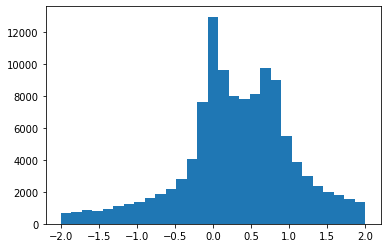

In [38]:
plt.hist(d_px, bins=bins)

(array([ 842.,  877.,  906.,  908., 1023., 1026., 1084., 1244., 1278.,
        1462., 1689., 2058., 2812., 4858., 8022., 6677., 3927., 3118.,
        2952., 3147., 3397., 3652., 3072., 2665., 2275., 2091., 1771.,
        1648., 1529.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

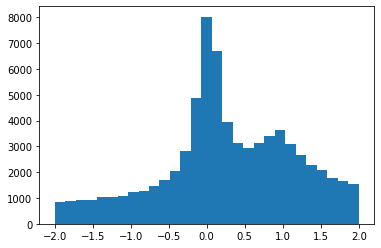

In [39]:
plt.hist(d_py, bins=bins)

(array([  238.,   284.,   301.,   355.,   388.,   545.,   616.,   797.,
         1067.,  1354.,  1982.,  3681.,  6988., 23410., 44443., 22353.,
         8022.,  4460.,  5279.,  4059.,  2640.,  1874.,  1333.,   960.,
          715.,   635.,   512.,   461.,   345.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

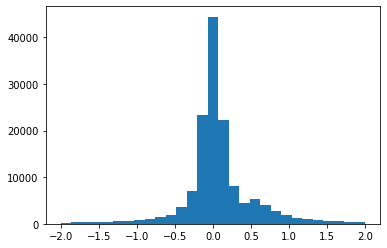

In [40]:
plt.hist(d_pz, bins=bins)